# Implementing SGD with Momentum

Stochastic Gradient Descent (SGD) is an **optimization** method used in neural networks.

This notebook is identical to `lesson2-sgd-my-reimplementation.ipynb`, except there is a final section where I implement SGD with momentum, and use animations to compare performance to using SGD without momentum

In [1]:
%matplotlib inline
# Get nicer looking graphs for retina displays
%config InlineBackend.figure_format = 'retina'
from fastai import *

## Understanding PyTorch with a Linear Regression Example

In [2]:
n=100

In [3]:
x = torch.ones(n,2) # n rows and 2 columns
x[:,0].uniform_(-1.,1) # fill first column with numbers drawn from uniform random distrib.
x[:5]

tensor([[ 0.2849,  1.0000],
        [-0.1558,  1.0000],
        [-0.9683,  1.0000],
        [-0.6639,  1.0000],
        [-0.7024,  1.0000]])

In [4]:
# Our target weights
a = tensor([3.,2]); a

tensor([3., 2.])

In [5]:
# Our linear equation
y = x@a + torch.rand(n)

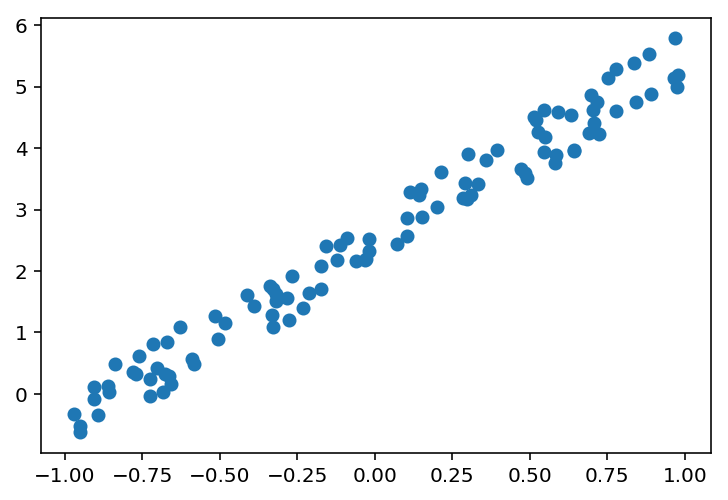

In [6]:
plt.scatter(x[:,0],y);

Now we will pretend we don't know what a, our weights, is. 

Our linear regression task is to find the weights (or parameters) of the line that best fits the dots plot above. 

The *error function* or *loss function* that we will use to find the weights of the line that best fits (minimizes the error of the loss function) the dots above is **mean squared error**.

In [7]:
def mse(y_hat,y): return ((y_hat-y)**2).mean()

Suppose we made the guess that the best weights a were `a = (-1.0,1.0)`. Here's how we'd compute `y_hat`, which is our prediction, and then find our error:

In [8]:
a = tensor([-1.,1])

In [9]:
y_hat = x@a

In [10]:
mse(y_hat,y)

tensor(7.7979)

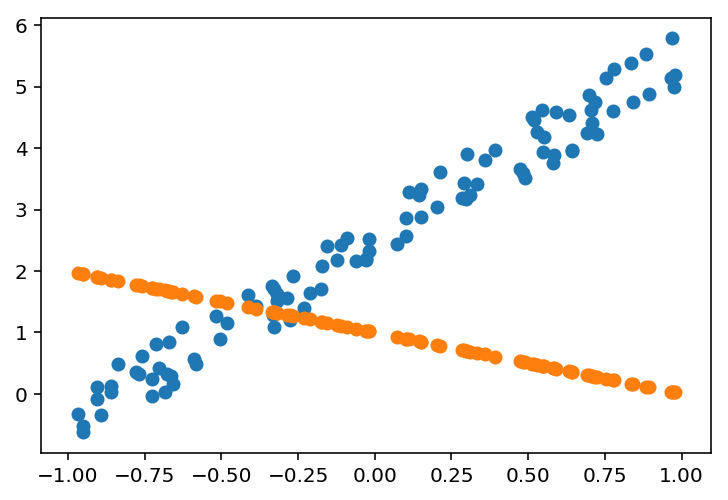

In [11]:
plt.scatter(x[:,0],y) # plot the original dots from above
plt.scatter(x[:,0],y_hat); # plot our guess for each dot if we use our guess for a

So we know the weights we guessed for a aren't very good, in that they help us to do a pretty lousy job of predicting the y value (`y_hat`) for each dot's x value.

But how do we update, improve, or *optimize* our guess for a, given that we can now measure how bad our initial guess was?

The *Gradient Descent* algorithm is just what we need to help us accomplish this task.

# Gradient Descent

Gradient descent is an algorithm that minimizes functions.

When given a function that's defined by a set of parameters (or weights), gradient descent starts with a (usually) randomly chosen initial set of parameter values, and then iteratively moves toward a set of parameter values that minimzes the function.

Each adjustment, or step, toward the best set of parameter values is done by moving in the negative direction of the function gradient (the derivative, or slope, of the function).

Intuitively, if the function (our mse loss function in this case) is increasing, it's slope would be positive. But since we want to find the minimum of this function, we obviously want to move in a direction opposite to the direction in which the function is increasing. 

Gradient descent will help us pick new values for our parameters that are a little bit less (or greater) than what that had just been, if our loss function increases (or decreases) with increasing values.

In [63]:
a = nn.Parameter(a); a

Parameter containing:
tensor([-1.,  1.], requires_grad=True)

In [64]:
def update():
    y_hat = x@a
    loss = mse(y, y_hat)
    if t%10 == 0: print(loss)
    loss.backward()
    with torch.no_grad():
        a.sub_(lr * a.grad)
        a.grad.zero_()

In [65]:
lr = 1e-1
for t in range(100): update()

tensor(7.3485, grad_fn=<MeanBackward1>)
tensor(1.5250, grad_fn=<MeanBackward1>)
tensor(0.4887, grad_fn=<MeanBackward1>)
tensor(0.2028, grad_fn=<MeanBackward1>)
tensor(0.1221, grad_fn=<MeanBackward1>)
tensor(0.0993, grad_fn=<MeanBackward1>)
tensor(0.0929, grad_fn=<MeanBackward1>)
tensor(0.0911, grad_fn=<MeanBackward1>)
tensor(0.0906, grad_fn=<MeanBackward1>)
tensor(0.0904, grad_fn=<MeanBackward1>)


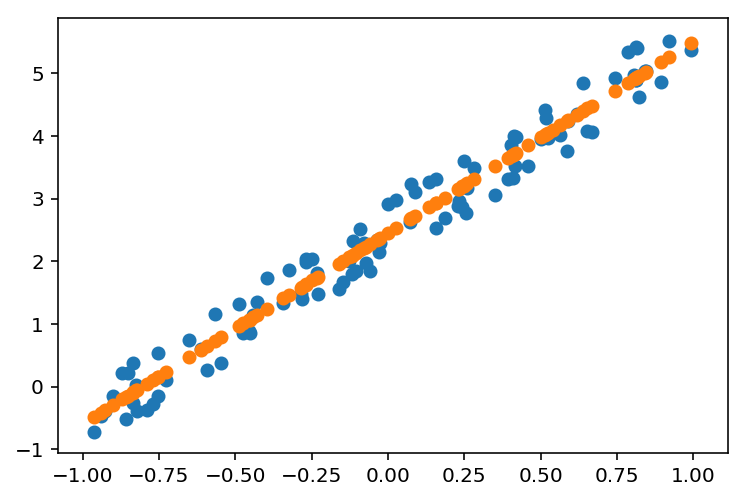

In [66]:
plt.scatter(x[:,0],y)
plt.scatter(x[:,0],(x@a).detach().numpy());

## Animation of Gradient Descent

In [12]:
from matplotlib import animation, rc
rc('animation', html='html5')

In [13]:
# Run the following commands to install the necessary libraries
# Be sure to restart the kernel after they all install
# ! sudo add-apt-repository -y ppa:mc3man/trusty-media  
# ! sudo apt-get update -y 
# ! sudo apt-get install -y ffmpeg  
# ! sudo apt-get install -y frei0r-plugins 

In [14]:
a = nn.Parameter(tensor([-1.,1]))

fig = plt.figure()
plt.scatter(x[:,0], y, c='orange')
line, = plt.plot((x[:,0]).detach().numpy(), (x@a).detach().numpy())
plt.close()

def animate(i):
    update()
    line.set_ydata((x@a).detach().numpy())
    return line,

In [30]:
# Run the above cells and then run the animation with various learning rates
lr = 1e-1
animation.FuncAnimation(fig, animate, np.arange(0,100), interval=20)

In [51]:
lr = 1e-2
animation.FuncAnimation(fig, animate, np.arange(0,100), interval=20)

In [70]:
lr = 1e-3
animation.FuncAnimation(fig, animate, np.arange(0,100), interval=20)

As the learning rate decreases, gradient descent makes much less progress toward finding the optimal set of weights/parameters that minimizes the loss function, within the timeframe of the animation.

Note, for classification problems, the loss function that we use is *cross entropy loss*. This is also known as *negative log likelihood* loss. It penalizes **incorrect confident predictions**, as well as **correct unconfident predictions**.

## Gradient Descent with Momentum

We can accelerate gradient descent by combining a decaying average of the  previous gradients with the current gradient, and then updating the model weights with that combination.

The effect of doing this is that if our model has recently been making consistent steps in the same direction relative to the loss function, each subsequent update will make larger and larger steps in this same direction (because decaying average of previous gradients is larger).

Conversely, if the opposite had been the case, and some updates had shifted weights in one direction, and then other updates had shifted in an opposite direction, our model is less confident about where it would need to go next (because the weighted average of previous gradients is smaller), and will be taking smaller steps at each update.

In [15]:
a = tensor([-1.,1])

In [16]:
a = nn.Parameter(a); a

Parameter containing:
tensor([-1.,  1.], requires_grad=True)

In [19]:
def update_with_momentum(iterations=100):
    prev_grad = 0. # Also known as 'velocity', starts at 0
    for t in range(iterations):
        y_hat = x@a
        loss = mse(y, y_hat)
        if t%10 == 0: print(loss)
        loss.backward()
        with torch.no_grad():
            prev_grad = lr * a.grad + mom * prev_grad
            a.sub_(prev_grad)
            a.grad.zero_()

In [90]:
lr = 1e-1
mom = 0.9
update_with_momentum(iterations=100)

tensor(8.0490, grad_fn=<MeanBackward1>)
tensor(1.0351, grad_fn=<MeanBackward1>)
tensor(0.4907, grad_fn=<MeanBackward1>)
tensor(0.1073, grad_fn=<MeanBackward1>)
tensor(0.1678, grad_fn=<MeanBackward1>)
tensor(0.0980, grad_fn=<MeanBackward1>)
tensor(0.0804, grad_fn=<MeanBackward1>)
tensor(0.0718, grad_fn=<MeanBackward1>)
tensor(0.0716, grad_fn=<MeanBackward1>)
tensor(0.0714, grad_fn=<MeanBackward1>)


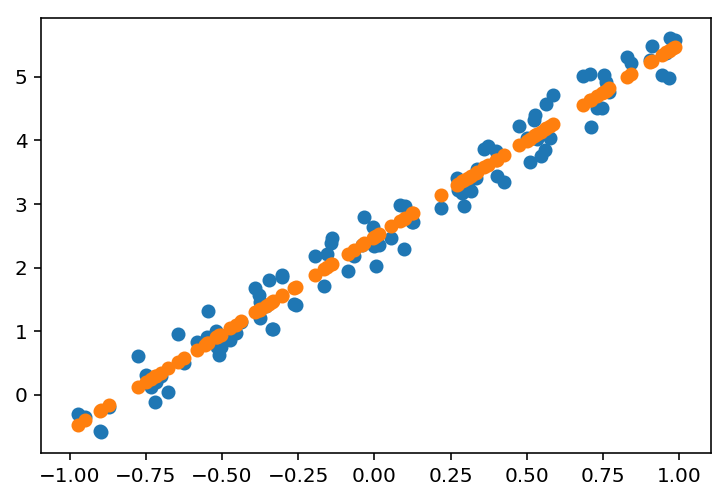

In [91]:
plt.scatter(x[:,0],y)
plt.scatter(x[:,0],(x@a).detach().numpy());

## Animation of Gradient Descent with Momentum

In [24]:
def update_with_momentum(iterations=100):
    prev_grad = 0.
    for t in range(iterations):
        y_hat = x@a
        loss = mse(y, y_hat)
        # if t%10 == 0: print(loss)
        loss.backward()
        with torch.no_grad():
            prev_grad = lr * a.grad + mom * prev_grad
            a.sub_(prev_grad)
            a.grad.zero_()

In [25]:
def animate(i):
    update_with_momentum(iterations=100)
    line.set_ydata((x@a).detach().numpy())
    return line,

In [27]:
# Run the animation with various momentums
lr = 1e-3
mom = 0.1
a = nn.Parameter(tensor([-1.,1]))
animation.FuncAnimation(fig, animate, np.arange(0,100), interval=20)

In [29]:
lr = 1e-3
mom = 0.5
a = nn.Parameter(tensor([-1.,1]))
animation.FuncAnimation(fig, animate, np.arange(0,100), interval=20)

In [30]:
lr = 1e-3
mom = 0.9
a = nn.Parameter(tensor([-1.,1]))
animation.FuncAnimation(fig, animate, np.arange(0,100), interval=20)

## Conclusion

In this case, using momentum got us to a lower loss, in a much quicker amount of time, holding learning rate constant.